In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Suppress most warnings for now

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Get Ocean Temperature Data (ORAS5)

In [3]:
fname = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ORAS5/1x1_grid/votemper/opa0_ext'
ds = xr.open_dataset(fname,decode_times=True)

### Get the top level as SST

In [4]:
sst = ds.votemper[:,0,:,:]

### Get nx,ny,nt,nt_train for use later

In [5]:
nx=len(ds['lon'])
ny=len(ds['lat'])
nt=len(ds['time'])
nt_train=600

### Make anomalies

In [6]:
sst_climo = sst.groupby('time.month').mean(dim='time')
sst_anom = sst.groupby('time.month') - sst_climo

### Make Nino3.4

In [7]:
#nino_anom = sst_anom.sel(lat=slice(-5,5),lon=slice(210,260)).mean(dim=['lat','lon'])
nino_anom = sst_anom.sel(lat=slice(-5,5),lon=slice(190,240)).mean(dim=['lat','lon'])

### Turn into categorization problem with 1's and 0's for warm and cold events

In [8]:
# Predictors ( aka Features ): Training on first 600 months 
X = sst_anom[0:nt_train,:,:].values

# Select El Nino and La Nina (Categorical Predictand)
yy = nino_anom[0:nt_train]
l_warm = ( yy > 0.5 )
l_cold = ( yy < 0.5 )
y = np.array([1*l_warm,1*l_cold]).T
y.shape

(600, 2)

### Make a keras model

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers

Using TensorFlow backend.


In [10]:
model = Sequential()
model.add(Dense(8, input_dim=nx*ny,activation='relu',
                kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01),
                bias_initializer='he_normal'))
model.add(Dense(8, activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(0.01),
                bias_initializer='he_normal'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD',loss='binary_crossentropy', metrics=['accuracy'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fit the model to the data

In [11]:
XX = X.reshape(nt_train,nx*ny)
XX[np.isnan(XX)] = 0.0
model.fit(XX, y, epochs=100, batch_size=60)

Epoch 1/100
600/600 [==============================] - 0s 742us/step - loss: 1.8048 - acc: 0.4700
Epoch 2/100
600/600 [==============================] - 0s 324us/step - loss: 0.8334 - acc: 0.6800
Epoch 3/100
600/600 [==============================] - 0s 306us/step - loss: 0.6530 - acc: 0.7367
Epoch 4/100
600/600 [==============================] - 0s 267us/step - loss: 0.5694 - acc: 0.7967
Epoch 5/100
600/600 [==============================] - 0s 264us/step - loss: 0.5161 - acc: 0.9367
Epoch 6/100
600/600 [==============================] - 0s 251us/step - loss: 0.4754 - acc: 0.9900
Epoch 7/100
600/600 [==============================] - 0s 255us/step - loss: 0.4475 - acc: 0.9950
Epoch 8/100
600/600 [==============================] - 0s 260us/step - loss: 0.4244 - acc: 0.9983
Epoch 9/100
600/600 [==============================] - 0s 281us/step - loss: 0.4087 - acc: 0.9983
Epoch 10/100
600/600 [==============================] - 0s 419us/step - loss: 0.3938 - acc: 0.9983
Epoch 11/100
600/60

### Apply `iNNvestigate`

In [12]:
import innvestigate
import innvestigate.utils

In [13]:
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(XX)

In [14]:
a[l_warm==True].shape

(145, 64800)

### Get El Nino Cases

In [15]:
a_warm=a[l_warm,:]
tmp=a_warm.shape

### Reshape to `time,lat,lon` and normalize

In [16]:
a=a_warm.reshape((tmp[0],ny,nx))

In [17]:
ds_time=ds['time'][0:nt_train]
ds_time=ds_time[l_warm==True]

### Make `xarray.Dataset`

In [18]:
ds_tmp=xr.DataArray(a,
                    coords={'time':ds_time,
                            'lat':ds['lat'].values,
                            'lon': ds['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp=ds_tmp.to_dataset(name='warm')

# Normalize by max value in grid
ds_lrp=ds_lrp/ds_lrp.max(dim=['lat','lon'])

### Plot

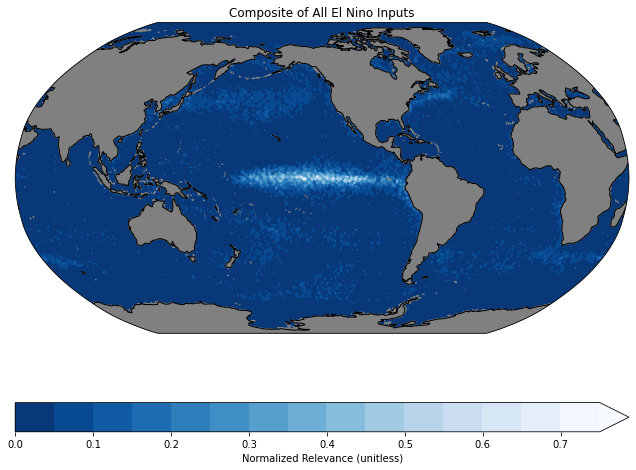

In [19]:
from cartopy.util import add_cyclic_point
clevs=np.arange(0.0,0.76,0.05)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_lrp['warm'].mean(dim='time'), coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('Composite of All El Nino Inputs')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')

### Plot May 1998

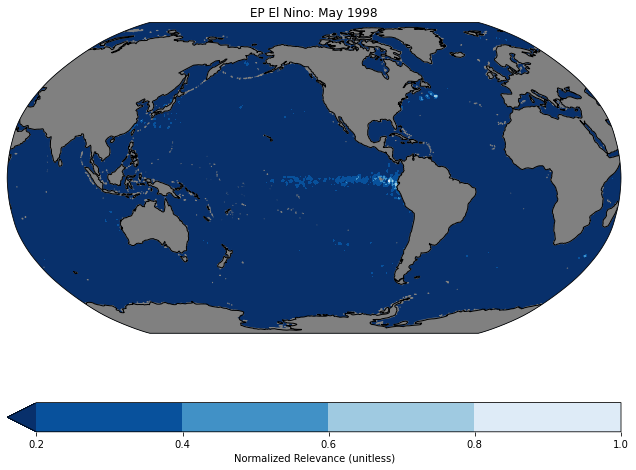

In [20]:
ds_may1998=ds_lrp['warm'].sel(time='1998-05-15')
clevs=np.arange(0.2,1.2,0.2)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_may1998, coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='min')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('EP El Nino: May 1998')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')

### Plot Feb 1987

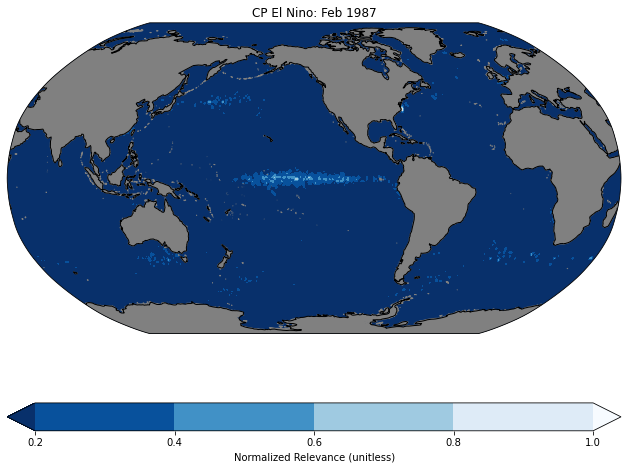

In [21]:
ds_feb1987=ds_lrp['warm'].sel(time='1987-02-15')
fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_feb1987, coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='both')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('CP El Nino: Feb 1987')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')